In [2]:
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import numpy as np
from encoder import *
import torch
import math
import glob
from scipy.stats import pearsonr

c:\anaconda3\envs\master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def correlate(model1, model2, data_input_1, data_input_2):
    return pearsonr(
        torch.softmax(model1(data_input_1), dim=1)[:, 1].detach().cpu().flatten(),
        torch.softmax(model2(data_input_2), dim=1)[:, 1].detach().cpu().flatten()
    )

"""
    # Forward pass through both encoders
    encoder_1 = model1.encoder(data_input_1)
    encoder_2 = model2.encoder(data_input_2)

    # Lists to store the intermediate outputs of the decoder blocks for both models
    decoder_block_outputs1 = []
    decoder_block_outputs2 = []

    # Hook function to capture outputs from each decoder block of model1
    def hook_fn1(module, input, output):
        decoder_block_outputs1.append(output)

    # Hook function to capture outputs from each decoder block of model2
    def hook_fn2(module, input, output):
        decoder_block_outputs2.append(output)

    # Register hooks for decoder blocks in both models
    for block in model1.decoder.blocks:
        block.register_forward_hook(hook_fn1)

    for block in model2.decoder.blocks:
        block.register_forward_hook(hook_fn2)

    # Forward pass through the decoders (the hooks will capture the intermediate outputs)
    decoder_1 = model1.decoder(*encoder_1)
    decoder_2 = model2.decoder(*encoder_2)

    # Get predictions
    preds1 = torch.softmax(model1(data_input_1), dim=1)[:, 1]
    preds2 = torch.softmax(model2(data_input_2), dim=1)[:, 1]

    # Encoder correlation
    corr_encoder = {}
    for i in range(1, len(encoder_1)):
        corr_encoder[i] = pearsonr(
            encoder_1[i].detach().cpu().numpy().flatten(),
            encoder_2[i].detach().cpu().numpy().flatten()
        )

    # Decoder correlation (using the outputs captured by the hooks)
    corr_decoder = {}
    for i in range(len(decoder_block_outputs1)):
        corr_decoder[i] = pearsonr(
            decoder_block_outputs1[i].detach().cpu().numpy().flatten(),
            decoder_block_outputs2[i].detach().cpu().numpy().flatten()
        )

    # Correlation of final predictions
    corr_preds = pearsonr(preds1.detach().cpu().flatten(), preds2.detach().cpu().flatten())"""



'\n    # Forward pass through both encoders\n    encoder_1 = model1.encoder(data_input_1)\n    encoder_2 = model2.encoder(data_input_2)\n\n    # Lists to store the intermediate outputs of the decoder blocks for both models\n    decoder_block_outputs1 = []\n    decoder_block_outputs2 = []\n\n    # Hook function to capture outputs from each decoder block of model1\n    def hook_fn1(module, input, output):\n        decoder_block_outputs1.append(output)\n\n    # Hook function to capture outputs from each decoder block of model2\n    def hook_fn2(module, input, output):\n        decoder_block_outputs2.append(output)\n\n    # Register hooks for decoder blocks in both models\n    for block in model1.decoder.blocks:\n        block.register_forward_hook(hook_fn1)\n\n    for block in model2.decoder.blocks:\n        block.register_forward_hook(hook_fn2)\n\n    # Forward pass through the decoders (the hooks will capture the intermediate outputs)\n    decoder_1 = model1.decoder(*encoder_1)\n    dec

In [4]:
model1 = smp.Unet(
            encoder_name=f"single_encoder_6",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model2 = smp.Unet(
            encoder_name=f"single_encoder_12",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model3 = smp.Unet(
            encoder_name="dual_encoder_dft",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model4 = smp.Unet(
            encoder_name="dual_resnet_encoder",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model5 = smp.Unet(
            encoder_name="resnet50",
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model6 = smp.Unet(
            encoder_name=f"single_encoder_24",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model7 = smp.Unet(
            encoder_name="dual_encoder_wav",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )


In [4]:
# Loading data from precomputed dataset
path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/test"
# Data/ms-dataset-chips\\95eff095-c3e9-4c12-bfde-1708b7e19bae\\s2\\S2A_MSIL1C_20170528T050611_N0205_R076_T44NNP_20170528T050606_00960-03063\\B12.tif'
data = np.load(f"{path}/10.npz", allow_pickle=True)
data = data["arr_0"][0]
X = data["image"]
X = torch.tensor(np.expand_dims(X, axis=0))
amps = data["amplitude"]
phases = data["phase"]
wavelets = torch.tensor(np.expand_dims(data["wavelet"], axis=0)).cuda(non_blocking=True).float()
X = X.cuda(non_blocking=True).float()
ap = torch.tensor(np.expand_dims(np.concatenate([amps, phases], axis=0), axis=0)).cuda(non_blocking=True).float()

X_ap = np.concatenate([X.cpu().numpy(), ap.cpu().numpy()], axis=1)  # Concatenate on CPU first
X_ap = torch.tensor(X_ap).cuda(non_blocking=True).float()

In [5]:
# Load model 1
model_weights_path_1 = glob.glob(f"trained_models/sen2_baseline_final_seed1/best_iou*")[0]
model1 = model1.cuda()
model1.eval()
cp = torch.load(model_weights_path_1)
model1.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_1} at epoch {cp['epoch_num']}")

"""# Load model 2
model_weights_path_2 = glob.glob(f"trained_models/dft2/best_iou*")[0]
model2 = model2.cuda()
model2.eval()
cp = torch.load(model_weights_path_2)
model2.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_2} at epoch {cp['epoch_num']}")"""

# Load model 3
model_weights_path_3 = glob.glob(f"trained_models/sen2_baseline_dft_final_seed1/best_iou*")[0]
model3 = model3.cuda()
model3.eval()
cp = torch.load(model_weights_path_3)
model3.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_3} at epoch {cp['epoch_num']}")

"""# Load model 4
model_weights_path_4 = glob.glob(f"trained_models/baseline_deep2/best_iou*")[0]
model4 = model4.cuda()
model4.eval()
cp = torch.load(model_weights_path_4)
model4.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_4} at epoch {cp['epoch_num']}")

# Load model 5
model_weights_path_5 = glob.glob(f"trained_models/deep2/best_iou*")[0]
model5 = model5.cuda()
model5.eval()
cp = torch.load(model_weights_path_5)
model5.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_5} at epoch {cp['epoch_num']}")"""

# Load model 6
model_weights_path_6 = glob.glob(f"trained_models/sen2_wavelet_final_seed1/best_iou*")[0]
model6 = model6.cuda()
model6.eval()
cp = torch.load(model_weights_path_6)
model6.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_6} at epoch {cp['epoch_num']}")

# Load model 7
model_weights_path_7 = glob.glob(f"trained_models/sen2_baseline_wavelet_final_seed1/best_iou*")[0]
model7 = model7.cuda()
model7.eval()
cp = torch.load(model_weights_path_7)
model7.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_7} at epoch {cp['epoch_num']}")

Loaded trained_models/sen2_baseline_final_seed1\best_iou_34_0.7808.pt at epoch 34
Loaded trained_models/sen2_baseline_dft_final_seed1\best_iou_40_0.7661.pt at epoch 40
Loaded trained_models/sen2_wavelet_final_seed1\best_iou_32_0.7884.pt at epoch 32
Loaded trained_models/sen2_baseline_wavelet_final_seed1\best_iou_33_0.7847.pt at epoch 33


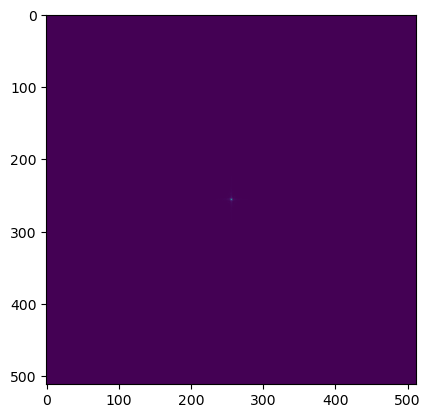

In [6]:
plt.imshow(X_ap[:, -12:, :, :].cpu().squeeze(0)[4, :, :])

# Load all sen2 models with different seeds

In [5]:
baseline = smp.Unet(
            encoder_name=f"single_encoder_6",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

dft = smp.Unet(
            encoder_name=f"single_encoder_12",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

dual_dft = smp.Unet(
            encoder_name="dual_encoder_dft",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

dual_deep = smp.Unet(
            encoder_name="dual_resnet_encoder",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

deep = smp.Unet(
            encoder_name="resnet50",
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

wavelet = smp.Unet(
            encoder_name=f"single_encoder_24",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

dual_wavelet = smp.Unet(
            encoder_name="dual_encoder_wav",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

In [6]:
baselines = ["baseline2", "sen2_baseline_final_seed1", "sen2_baseline_final_seed2", "sen2_baseline_final_seed3"]
dfts = ["dft2", "sen2_dft_final_seed1", "sen2_dft_final_seed2", "sen2_dft_final_seed3"]
wavelets = ["wavelet2", "sen2_wavelet_final_seed1", "sen2_wavelet_final_seed2", "sen2_wavelet_final_seed3"]
deeps = ["deep", "sen2_deep_final_seed1", "sen2_deep_final_seed2", "sen2_deep_final_seed3"]
baseline_dfts = ["baseline_dft2", "sen2_baseline_dft_final_seed1", "sen2_baseline_dft_final_seed2", "sen2_baseline_dft_final_seed3"]
baseline_wavelets = ["baseline_wavelet2", "sen2_baseline_wavelet_final_seed1", "sen2_baseline_wavelet_final_seed2", "sen2_baseline_wavelet_final_seed3"]
baseline_deeps = ["baseline_deep2", "sen2_baseline_deep_final_seed1", "sen2_baseline_deep_final_seed2", "sen2_baseline_deep_final_seed3"]
model_dict = {baseline: baselines, dft: dfts}
all_runs = [baselines, dfts, wavelets, deeps, baseline_dfts, baseline_wavelets, baseline_deeps]
base = list(zip([baseline, dft, wavelet, deep, dual_dft, dual_wavelet, dual_deep], [i[0] for i in all_runs]))
seed1 = list(zip([baseline, dft, wavelet, deep, dual_dft, dual_wavelet, dual_deep], [i[1] for i in all_runs]))
seed2 = list(zip([baseline, dft, wavelet, deep, dual_dft, dual_wavelet, dual_deep], [i[2] for i in all_runs]))
seed3 = list(zip([baseline, dft, wavelet, deep, dual_dft, dual_wavelet, dual_deep], [i[3] for i in all_runs]))

In [7]:
def correlate_models(model_list, n):
    corr_matrix = np.ones((len(model_list), len(model_list)))
    for i in range(len(model_list)):
        for j in range(len(model_list)):
            if i == j:
                continue
            # load_model1
            path = glob.glob(f"trained_models/{model_list[i][1]}/best_iou*")[0]
            model1 = model_list[i][0].cuda()
            model1.eval()
            cp = torch.load(path)
            model1.load_state_dict(cp["model_state_dict"])

            # load_model2
            path = glob.glob(f"trained_models/{model_list[j][1]}/best_iou*")[0]
            model2 = model_list[j][0].cuda()
            model2.eval()
            cp = torch.load(path)
            model2.load_state_dict(cp["model_state_dict"])
            avg = []
            for k in range(n):
                # Loading data from precomputed dataset
                path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/test"
                data = np.load(f"{path}/{k}.npz", allow_pickle=True)
                data = data["arr_0"][0]
                X = data["image"]
                X = torch.tensor(np.expand_dims(X, axis=0))
                X = X.cuda(non_blocking=True).float()
                a = data["amplitude"]
                p = data["phase"]
                ap = np.concatenate([a, p], axis=0)
                ap = np.expand_dims(ap, axis=0)
                ap = torch.tensor(ap).cuda(non_blocking=True).float()
                X_ap = torch.cat([X, ap], dim=1)
                model_input = [X, ap, X, X[:, :3, :, :], X_ap, X, X]
                avg.append(correlate(model1, model2, model_input[i], model_input[j])[0])
            corr_matrix[i, j] = np.mean(avg)
    return corr_matrix


In [8]:
res1 = correlate_models(seed1, 50)

In [9]:
res2 = correlate_models(seed2, 50)

In [10]:
res3 = correlate_models(seed3, 50)

In [17]:
mean_res = np.round(np.mean(np.stack((res1, res2, res3)), axis=0), 3)

In [11]:
print(np.round(res1, 3)) #50
print(np.round(res2, 3)) #50
print(np.round(res3, 3)) #50

[[1.    0.014 0.801 0.288 0.781 0.805 0.718]
 [0.014 1.    0.019 0.009 0.016 0.012 0.002]
 [0.801 0.019 1.    0.277 0.742 0.812 0.679]
 [0.288 0.009 0.277 1.    0.258 0.295 0.275]
 [0.781 0.016 0.742 0.258 1.    0.781 0.676]
 [0.805 0.012 0.812 0.295 0.781 1.    0.703]
 [0.718 0.002 0.679 0.275 0.676 0.703 1.   ]]
[[ 1.    -0.01   0.786  0.284  0.747  0.762  0.759]
 [-0.01   1.     0.007  0.025  0.005  0.001  0.004]
 [ 0.786  0.007  1.     0.319  0.77   0.808  0.796]
 [ 0.284  0.025  0.319  1.     0.29   0.301  0.306]
 [ 0.747  0.005  0.77   0.29   1.     0.745  0.785]
 [ 0.762  0.001  0.808  0.301  0.745  1.     0.791]
 [ 0.759  0.004  0.796  0.306  0.785  0.791  1.   ]]
[[ 1.    -0.006  0.747  0.263  0.703  0.757  0.745]
 [-0.006  1.     0.003  0.023  0.014  0.005  0.002]
 [ 0.747  0.003  1.     0.243  0.679  0.84   0.738]
 [ 0.263  0.023  0.243  1.     0.336  0.281  0.301]
 [ 0.703  0.014  0.679  0.336  1.     0.75   0.714]
 [ 0.757  0.005  0.84   0.281  0.75   1.     0.765]
 [ 0.74

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
def create_plot(res, title, name):
    df = pd.DataFrame(res)
    cols = ['baseline', 'dft', 'wavelet', 'deep', 'baseline_dft', 'baseline_wavelet', 'baseline_deep']

    # Create a pandas DataFrame with row and column labels
    df = pd.DataFrame(np.round(res, 3), columns=cols, index=cols)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="coolwarm", cbar=False, fmt=".3f", linewidths=0.9)
    plt.xticks(rotation=30)  # Rotate x-axis labels by 45 degrees
    # Customize the plot
    plt.title(title)
    plt.savefig(f'{name}.png', transparent=True, bbox_inches='tight', pad_inches=0.2)
    # Show the plot
    plt.show()

In [9]:
matrix1 = np.array([
    [1.000, 0.014, 0.801, 0.288, 0.781, 0.805, 0.718],
    [0.014, 1.000, 0.019, 0.009, 0.016, 0.012, 0.002],
    [0.801, 0.019, 1.000, 0.277, 0.742, 0.812, 0.679],
    [0.288, 0.009, 0.277, 1.000, 0.258, 0.295, 0.275],
    [0.781, 0.016, 0.742, 0.258, 1.000, 0.781, 0.676],
    [0.805, 0.012, 0.812, 0.295, 0.781, 1.000, 0.703],
    [0.718, 0.002, 0.679, 0.275, 0.676, 0.703, 1.000]
])

# Matrix 2
matrix2 = np.array([
    [1.000, -0.010, 0.786, 0.284, 0.747, 0.762, 0.759],
    [-0.010, 1.000, 0.007, 0.025, 0.005, 0.001, 0.004],
    [0.786, 0.007, 1.000, 0.319, 0.770, 0.808, 0.796],
    [0.284, 0.025, 0.319, 1.000, 0.290, 0.301, 0.306],
    [0.747, 0.005, 0.770, 0.290, 1.000, 0.745, 0.785],
    [0.762, 0.001, 0.808, 0.301, 0.745, 1.000, 0.791],
    [0.759, 0.004, 0.796, 0.306, 0.785, 0.791, 1.000]
])

# Matrix 3
matrix3 = np.array([
    [1.000, -0.006, 0.747, 0.263, 0.703, 0.757, 0.745],
    [-0.006, 1.000, 0.003, 0.023, 0.014, 0.005, 0.002],
    [0.747, 0.003, 1.000, 0.243, 0.679, 0.840, 0.738],
    [0.263, 0.023, 0.243, 1.000, 0.336, 0.281, 0.301],
    [0.703, 0.014, 0.679, 0.336, 1.000, 0.750, 0.714],
    [0.757, 0.005, 0.840, 0.281, 0.750, 1.000, 0.765],
    [0.745, 0.002, 0.738, 0.301, 0.714, 0.765, 1.000]
])
mean_res = np.round(np.mean(np.stack((matrix1, matrix2, matrix3)), axis=0), 3)

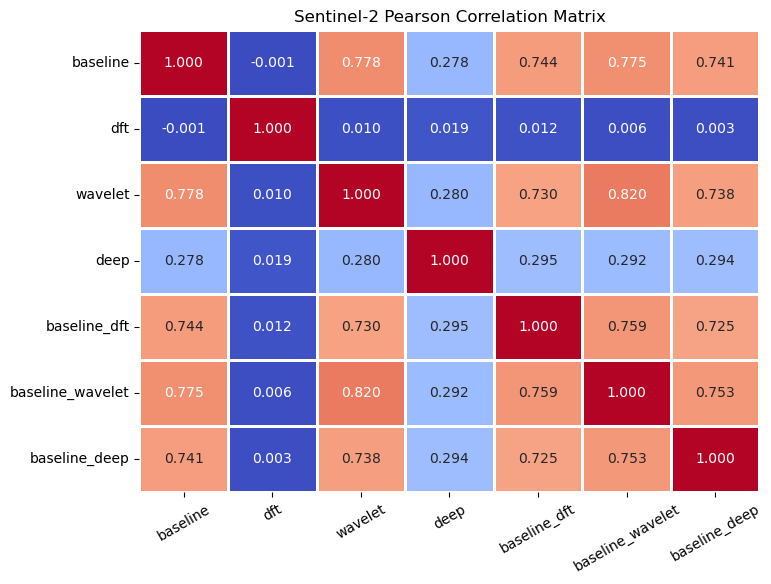

In [15]:
create_plot(mean_res, "Sentinel-2 Pearson Correlation Matrix", "sen2corr")
#create_plot(res2)
#create_plot(res3)

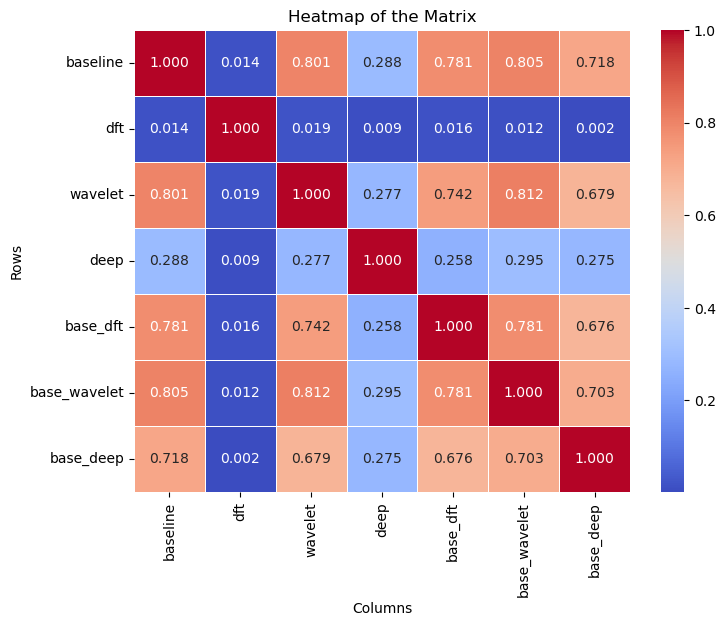

In [85]:

df = pd.DataFrame(res1)
cols = ['baseline', 'dft', 'wavelet', 'deep', 'base_dft', 'base_wavelet', 'base_deep']

# Create a pandas DataFrame with row and column labels
df = pd.DataFrame(np.round(res1, 3), columns=cols, index=cols)

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="coolwarm", cbar=True, fmt=".3f", linewidths=0.5)

# Customize the plot
plt.title('Heatmap of the Matrix')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Show the plot
plt.show()

In [108]:
def corr_avg(n):
    avg1, avg2, avg3 = [], [], []
    for i in range(n):
        # Loading data from precomputed dataset
        path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/test"
        data = np.load(f"{path}/{i}.npz", allow_pickle=True)
        data = data["arr_0"][0]
        X = data["image"]
        X = torch.tensor(np.expand_dims(X, axis=0))
        X = X.cuda(non_blocking=True).float()
        a = data["amplitude"]
        p = data["phase"]
        ap = np.concatenate([a, p], axis=0)
        ap = np.expand_dims(ap, axis=0)
        ap = torch.tensor(ap).cuda(non_blocking=True).float()
        X_ap = torch.cat([X, ap], dim=1)

        seed1_corr = correlate_models(seed1, [X, ap, X, X[:, :3, :, :], X_ap, X, X])
        seed2_corr = correlate_models(seed2, [X, ap, X, X[:, :3, :, :], X_ap, X, X])
        seed3_corr = correlate_models(seed3, [X, ap, X, X[:, :3, :, :], X_ap, X, X])
        avg1.append(seed1_corr)
        avg2.append(seed2_corr)
        avg3.append(seed3_corr)
    return np.mean(np.stack(avg1), axis=0), np.mean(np.stack(avg2), axis=0), np.mean(np.stack(avg3), axis=0), avg1, avg2, avg3

In [109]:
mean1, mean2, mean3, avg1, avg2, avg3 = corr_avg(5)

# Correlation Sen1

In [42]:
baseline = smp.Unet(
            encoder_name=f"single_encoder_6.2",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

dft = smp.Unet(
            encoder_name=f"single_encoder_12.2",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

dual_dft = smp.Unet(
            encoder_name="dual_encoder_dft.2",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

dual_deep = smp.Unet(
            encoder_name="dual_resnet_encoder.2",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

deep = smp.Unet(
            encoder_name="resnet50",
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

wavelet = smp.Unet(
            encoder_name=f"single_encoder_24.2",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

dual_wavelet = smp.Unet(
            encoder_name="dual_encoder_wav.2",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

In [48]:
baselines = ["baseline2", "sen1_baseline_final_seed1", "sen1_baseline_final_seed2", "sen1_baseline_final_seed3"]
dfts = ["dft2", "sen1_dft_final_seed1", "sen1_dft_final_seed2", "sen1_dft_final_seed3"]
wavelets = ["wavelet2", "sen1_wavelet_final_seed1", "sen1_wavelet_final_seed2", "sen1_wavelet_final_seed3"]
deeps = ["deep", "sen1_deep_final_seed1", "sen1_deep_final_seed2", "sen1_deep_final_seed3"]
baseline_dfts = ["baseline_dft2", "sen1_baseline_dft_final_seed1", "sen1_baseline_dft_final_seed2", "sen1_baseline_dft_final_seed3"]
baseline_wavelets = ["baseline_wavelet2", "sen1_baseline_wavelet_final_seed1", "sen1_baseline_wavelet_final_seed2", "sen1_baseline_wavelet_final_seed3"]
baseline_deeps = ["baseline_deep2", "sen1_baseline_deep_final_seed1", "sen1_baseline_deep_final_seed2", "sen1_baseline_deep_final_seed3"]
model_dict = {baseline: baselines, dft: dfts}
all_runs = [baselines, dfts, wavelets, deeps, baseline_dfts, baseline_wavelets, baseline_deeps]
base = list(zip([baseline, dft, wavelet, deep, dual_dft, dual_wavelet, dual_deep], [i[0] for i in all_runs]))  # Lists of [(run, name), ...]
seed1 = list(zip([baseline, dft, wavelet, deep, dual_dft, dual_wavelet, dual_deep], [i[1] for i in all_runs]))
seed2 = list(zip([baseline, dft, wavelet, deep, dual_dft, dual_wavelet, dual_deep], [i[2] for i in all_runs]))
seed3 = list(zip([baseline, dft, wavelet, deep, dual_dft, dual_wavelet, dual_deep], [i[3] for i in all_runs]))

In [49]:
def correlate_models(model_list, n):
    corr_matrix = np.ones((len(model_list), len(model_list)))
    for i in range(len(model_list)):
        for j in range(len(model_list)):
            if i == j:
                continue
            # load_model1
            path = glob.glob(f"trained_models/{model_list[i][1]}/best_iou*")[0]
            model1 = model_list[i][0].cuda()
            model1.eval()
            cp = torch.load(path)
            model1.load_state_dict(cp["model_state_dict"])

            # load_model2
            path = glob.glob(f"trained_models/{model_list[j][1]}/best_iou*")[0]
            model2 = model_list[j][0].cuda()
            model2.eval()
            cp = torch.load(path)
            model2.load_state_dict(cp["model_state_dict"])
            avg = []
            for k in range(n):
                # Loading data from precomputed dataset
                path = "D:/Uni/Masterarbeit/final_sen1/test"
                data = np.load(f"{path}/{k}.npz", allow_pickle=True)
                data = data["arr_0"][0]
                X = data["image"]
                X = torch.tensor(np.expand_dims(X, axis=0))
                X = X.cuda(non_blocking=True).float()
                a = data["amplitude"]
                p = data["phase"]
                ap = np.concatenate([a, p], axis=0)
                ap = np.expand_dims(ap, axis=0)
                ap = torch.tensor(ap).cuda(non_blocking=True).float()
                X_ap = torch.cat([X, ap], dim=1)

                # Load deep data
                path = "D:/Uni/Masterarbeit/final_sen1_deep/test"
                data = np.load(f"{path}/{k}.npz", allow_pickle=True)
                data = data["arr_0"][0]
                deep_X = data["image"]
                deep_X = torch.tensor(np.expand_dims(deep_X, axis=0))
                deep_X = deep_X.cuda(non_blocking=True).float()

                model_input = [X, ap, X, deep_X, X_ap, X, deep_X]
                avg.append(correlate(model1, model2, model_input[i], model_input[j])[0])
            corr_matrix[i, j] = np.mean(avg)
    return corr_matrix

In [52]:
sen1_res1 = correlate_models(seed1, 50)
sen1_res2 = correlate_models(seed2, 50)
sen1_res3 = correlate_models(seed3, 50)

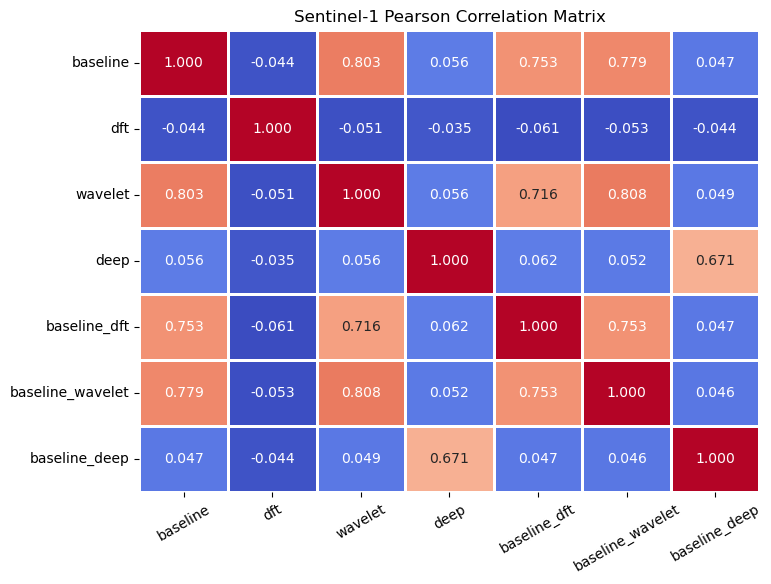

In [17]:
#mean_res2 = np.round(np.mean(np.stack((sen1_res1, sen1_res2, sen1_res3)), axis=0), 3)
mean_res2 = np.array([
    [1.00, -0.044, 0.803, 0.056, 0.753, 0.779, 0.047],
    [-0.044, 1.00, -0.051, -0.035, -0.061, -0.053, -0.044],
    [0.803, -0.051, 1.00, 0.056, 0.716, 0.808, 0.049],
    [0.056, -0.035, 0.056, 1.00, 0.062, 0.052, 0.671],
    [0.753, -0.061, 0.716, 0.062, 1.00, 0.753, 0.047],
    [0.779, -0.053, 0.808, 0.052, 0.753, 1.00, 0.046],
    [0.047, -0.044, 0.049, 0.671, 0.047, 0.046, 1.00]
])
create_plot(mean_res2, "Sentinel-1 Pearson Correlation Matrix", "sen1corr")

# Load 2 basemodels with different seed and compare 

In [29]:
def calculate_mean_standard_deviation(numbers):
    # Step 1: Calculate the mean
    mean = sum(numbers) / len(numbers)
    
    # Step 2: Calculate the variance
    variance = sum((x - mean) ** 2 for x in numbers) / len(numbers)
    
    # Step 3: Take the square root of the variance
    standard_deviation = math.sqrt(variance)
    
    return mean, standard_deviation

In [ ]:
def load_model(model_list, model):
    # Load all models
    for model_name in model_list:
        path = glob.glob(f"trained_models/{model_name}/best_iou*")[0]
        model = model.cuda()
        model.eval()
        cp = torch.load(path)
        model.load_state_dict(cp["model_state_dict"])
        print(f"Loaded {path} at epoch {cp['epoch_num']}")
    avg = 0
    for i in range(50):
        # Loading data from precomputed dataset
        path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/test"
        data = np.load(f"{path}/{i}.npz", allow_pickle=True)
        data = data["arr_0"][0]
        X = data["image"]
        X = torch.tensor(np.expand_dims(X, axis=0))
        X = X.cuda(non_blocking=True).float()

        corr_pred = correlate(model, model3, X, X_ap, True)
        avg.append(corr_pred[0])
        print(f"model{i}: {corr_pred}")
    print(calculate_mean_standard_deviation(avg))
    

In [6]:
baseline1 = smp.Unet(
            encoder_name=f"single_encoder_6",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

baseline2 = smp.Unet(
            encoder_name=f"single_encoder_6",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

# Load model 1
basline_path1 = glob.glob(f"trained_models/sen2_baseline_final_seed1/best_iou*")[0]
baseline1 = baseline1.cuda()
baseline1.eval()
cp = torch.load(basline_path1)
baseline1.load_state_dict(cp["model_state_dict"])
print(f"Loaded {basline_path1} at epoch {cp['epoch_num']}")

# Load model 1
basline_path2 = glob.glob(f"trained_models/sen2_baseline_final_seed2/best_iou*")[0]
baseline2 = baseline1.cuda()
baseline2.eval()
cp = torch.load(basline_path2)
baseline2.load_state_dict(cp["model_state_dict"])
print(f"Loaded {basline_path2} at epoch {cp['epoch_num']}")
avg = []
for i in range(50):
    # Loading data from precomputed dataset
    path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/test"
    # Data/ms-dataset-chips\\95eff095-c3e9-4c12-bfde-1708b7e19bae\\s2\\S2A_MSIL1C_20170528T050611_N0205_R076_T44NNP_20170528T050606_00960-03063\\B12.tif'
    data = np.load(f"{path}/{i}.npz", allow_pickle=True)
    data = data["arr_0"][0]
    X = data["image"]
    X = torch.tensor(np.expand_dims(X, axis=0))
    X = X.cuda(non_blocking=True).float()

    corr_pred = correlate(baseline1, model3, X, X_ap)
    avg.append(corr_pred[0])
    print(f"model{i}: {corr_pred}")
print(calculate_mean_standard_deviation(avg))

Loaded trained_models/sen2_baseline_final_seed1\best_iou_34_0.7808.pt at epoch 34
Loaded trained_models/sen2_baseline_final_seed2\best_iou_18_0.7539.pt at epoch 18


NameError: name 'model3' is not defined

In [ ]:
# Sentinel-1
params = [ap, X_ap, X, X[:, :3, :, :], wavelets, X]
i = 2
for model, params in zip([model2, model3, model4, model5, model6, model7], params):
    corr_enc, corr_dec, corr_pred = correlate(model1, model, X, params, True)
    print(f"model{i}: {corr_enc}, {corr_dec}, {corr_pred}")
    i += 1
    torch.cuda.empty_cache()

C:\Users\The Son\AppData\Local\Temp\ipykernel_9412\322673249.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bar_names, rotation=45, ha="right")
C:\Users\The Son\AppData\Local\Temp\ipykernel_9412\322673249.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bar_names, rotation=45, ha="right")
C:\Users\The Son\AppData\Local\Temp\ipykernel_9412\322673249.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bar_names, rotation=45, ha="right")
C:\Users\The Son\AppData\Local\Temp\ipykernel_9412\322673249.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bar_names, rotation=45, 

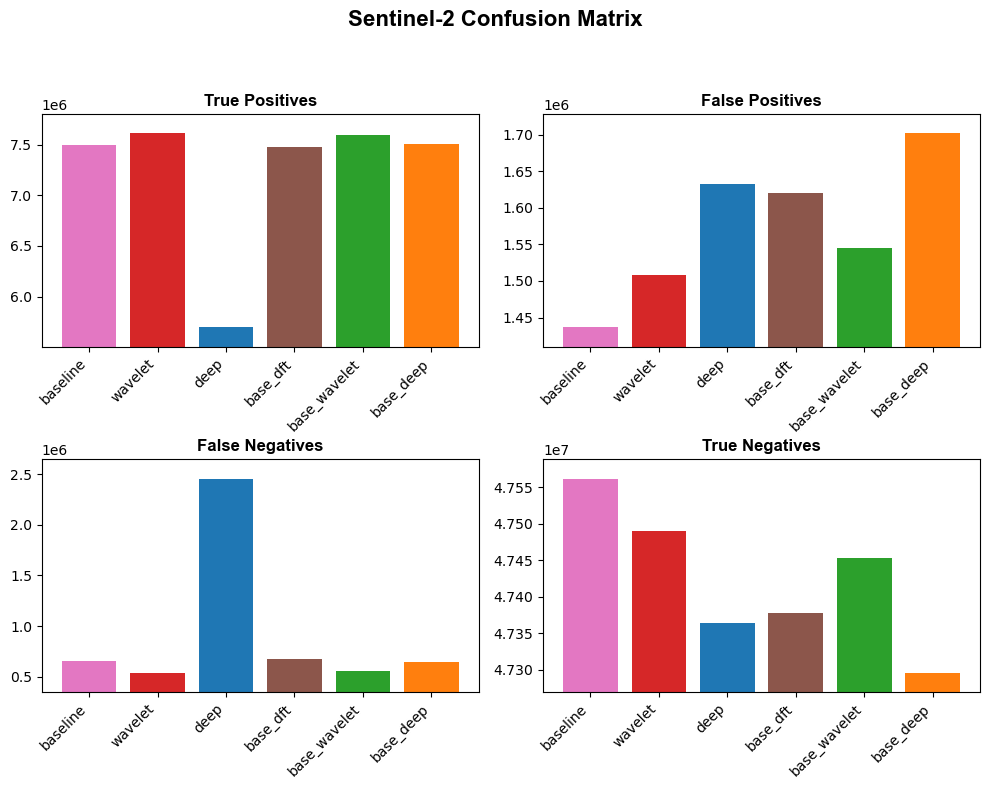

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for 4 bar plots (8 bars in each)
fp = [1436348.333, 16087815, 1508318.333, 1633331.333, 1619918, 1545222.667, 1702004.333]
tn = [47561370.667, 32909904, 47489400.667, 47364387.667, 47377801, 47452496.333, 47295714.667]
fn = [654591, 3832236.667, 537183, 2455275.333, 673583, 552869, 643643.333]
tp = [7495082, 4317436.333, 7612490, 5694397.667, 7476090, 7596804, 7506029.667]
data = np.array([tp, fp, fn, tn])

# Without dft
fp = [1436348.333, 1508318.333, 1633331.333, 1619918, 1545222.667, 1702004.333]
tn = [47561370.667, 47489400.667, 47364387.667, 47377801, 47452496.333, 47295714.667]
fn = [654591, 537183, 2455275.333, 673583, 552869, 643643.333]
tp = [7495082, 7612490, 5694397.667, 7476090, 7596804, 7506029.667]
data = np.array([tp, fp, fn, tn])

# Custom names and colors for the bars
bar_names = ['baseline', 'wavelet', 'deep', 'base_dft', 'base_wavelet', 'base_deep']
colors = ['#E377C2', '#D62728', '#1F77B4', '#8C564B', '#2CA02C', '#FF7F0E']
q_names = ["True Positives", "False Positives", "False Negatives", "True Negatives"]

# Create the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot bar charts in each quadrant of the confusion matrix
for i, ax in enumerate(axes.flat):
    ax.bar(bar_names, data[i], color=colors)
    ax.set_title(q_names[i], fontweight='bold', fontname="Arial")
    ax.set_xticklabels(bar_names, rotation=45, ha="right")
    # Calculate the range of the data in the current quadrant
    min_value = np.min(data[i])
    max_value = np.max(data[i])

    # Zoom into the region where most of the values lie (adding padding around min and max)
    padding = (max_value - min_value) * 0.1  # 10% padding
    ax.set_ylim(min_value - padding, max_value + padding)

# Add a title for the entire figure
fig.suptitle("Sentinel-2 Confusion Matrix", fontsize=16, fontweight='bold', fontname="Arial")

# Adjust layout for better visualization
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the title's space to avoid overlap
plt.savefig(f'conf_sen2.png', transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()



C:\Users\The Son\AppData\Local\Temp\ipykernel_2256\1872605147.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bar_names, rotation=30, ha="right", fontname='DejaVu Sans')
C:\Users\The Son\AppData\Local\Temp\ipykernel_2256\1872605147.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bar_names, rotation=30, ha="right", fontname='DejaVu Sans')
C:\Users\The Son\AppData\Local\Temp\ipykernel_2256\1872605147.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bar_names, rotation=30, ha="right", fontname='DejaVu Sans')
C:\Users\The Son\AppData\Local\Temp\ipykernel_2256\1872605147.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ti

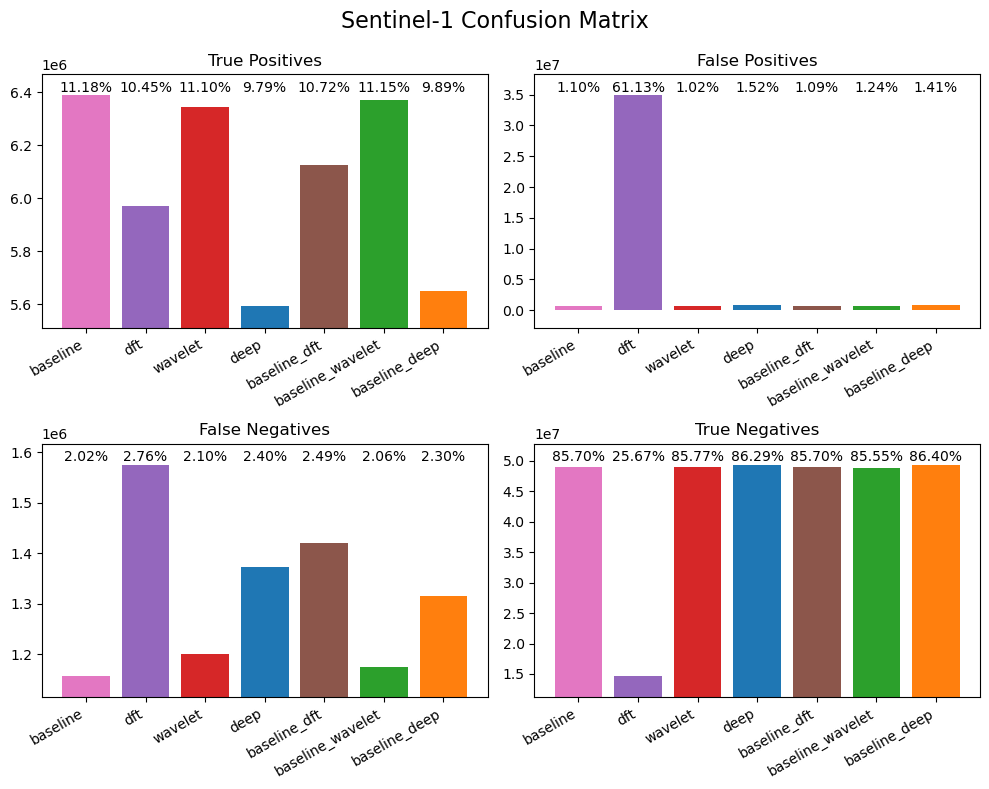

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Sen1
fp = [628201, 34934112, 585246.667, 868482.333, 624068, 710906, 806031.667]
tn = [48973415, 14667504, 49016369.333, 49314392.667,48977548, 48890710, 49376843.333]
fn = [1156645.333, 1575444.333, 1199959.667, 1372352, 1420741.667, 1174909.667, 1314634.333]
tp = [6389130.667, 5970331.667, 6345816.333, 5592165, 6125034.333, 6370866.333, 5649882.667]
data = np.array([tp, fp, fn, tn])
"""# Sen1 without dft
fp = [628201, 585246.667, 868482.333, 624068, 710906, 806031.667]
tn = [48973415, 49016369.333, 49314392.667,48977548, 48890710, 49376843.333]
fn = [1156645.333, 1199959.667, 1372352, 1420741.667, 1174909.667, 1314634.333]
tp = [6389130.667, 6345816.333, 5592165, 6125034.333, 6370866.333, 5649882.667]
data = np.array([tp, fp, fn, tn])"""


"""# Sen2
fp = [1436348.333, 16087815, 1508318.333, 1633331.333, 1619918, 1545222.667, 1702004.333]
tn = [47561370.667, 32909904, 47489400.667, 47364387.667, 47377801, 47452496.333, 47295714.667]
fn = [654591, 3832236.667, 537183, 2455275.333, 673583, 552869, 643643.333]
tp = [7495082, 4317436.333, 7612490, 5694397.667, 7476090, 7596804, 7506029.667]
data = np.array([tp, fp, fn, tn])

# Without dft
fp = [1436348.333, 1508318.333, 1633331.333, 1619918, 1545222.667, 1702004.333]
tn = [47561370.667, 47489400.667, 47364387.667, 47377801, 47452496.333, 47295714.667]
fn = [654591, 537183, 2455275.333, 673583, 552869, 643643.333]
tp = [7495082, 7612490, 5694397.667, 7476090, 7596804, 7506029.667]
data = np.array([tp, fp, fn, tn])"""

# Custom names and colors for the bars
bar_names = ['baseline', 'dft', 'wavelet', 'deep', 'baseline_dft', 'baseline_wavelet', 'baseline_deep']
colors = ['#E377C2','#9467BD', '#D62728', '#1F77B4', '#8C564B', '#2CA02C', '#FF7F0E']  #'#9467BD'
q_names = ["True Positives", "False Positives", "False Negatives", "True Negatives"]

# Create the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Option to zoom into the significant range
for i, ax in enumerate(axes.flat):
    # Calculate the total sum for each quadrant (can be customized based on your need)
    total = tp[i] + fp[i] + fn[i] + tn[i]

    ax.bar(bar_names, data[i], color=colors)
    ax.set_title(q_names[i], fontname='DejaVu Sans')
    
    # Make the x-axis labels bold and use the Helvetica font
    ax.set_xticklabels(bar_names, rotation=30, ha="right", fontname='DejaVu Sans')

    # Calculate the range of the data in the current quadrant
    min_value = np.min(data[i])
    max_value = np.max(data[i])

    # Zoom into the region where most of the values lie (adding padding around min and max)
    padding = (max_value - min_value) * 0.1  # 10% padding
    ax.set_ylim(min_value - padding, max_value + padding)

    # Annotate each x-tick (predicted class) with the percentage
    for j, v in enumerate(data[i]):
        percentage = (v / total) * 100  # Calculate the percentage
        ax.text(j, max_value + (max_value - min_value) * 0.001, f'{percentage:.2f}%',  # Increased the multiplier from 0.02 to 0.05
                ha='center', va='bottom', fontsize=10)

# Add a title for the entire figure with the Helvetica font
fig.suptitle("Sentinel-1 Confusion Matrix", fontsize=16, fontname='DejaVu Sans')

# Adjust layout for better visualization
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the title's space to avoid overlap
plt.savefig(f'conf_sen1.png', transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

